# Overview

Home Credit社は、1997年にチェコ共和国で設立され、オランダに本社を置く国際的なノンバンク金融機関である。<br>
同社は10か国で事業を展開しており、主に信用履歴がない人々への分割払いに重点を置いている。<br>
今回は、顧客情報と返済情報をもとに、新たな顧客の返済リスクの有無を予測するモデルを作成する。

# Module

In [ ]:
import gc
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Dataset

メインデータセットはapplication.csvであり、それに紐づいていくつかのサブデータセットが用意されている。<br>
今回使用するデータセットについて、いくつか中身を見ていく。

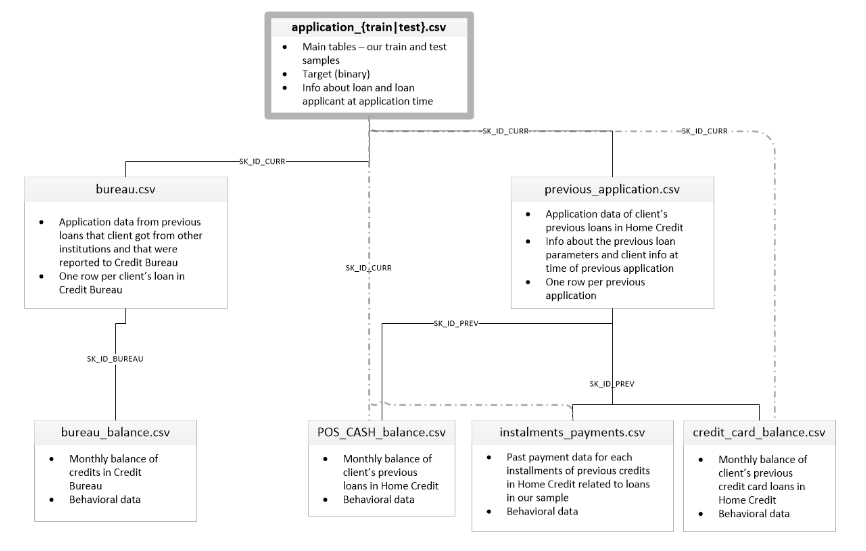

・application_{train|test}.csv：Home Credit社が持つデータで、返済リスクの有無とそれに対応する顧客の個人情報がまとめられているデータ<br>
・bureau.csv：Home Credit社以外での融資情報<br>
・POS_CASH_balance.csv：bureauの負債残高の履歴<br>
・credit_card_balance.csv：クレジットカードの使用に関する情報<br>
・previous_application.csv：Home Credit社における過去の融資情報

In [ ]:
train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')

print(train.shape)
print(train.isnull().sum().sum())
train.head()

目的変数はTARGETであり、値は以下の2つが与えられている。

・0：返済リスクなし<br>
・1：過去に支払いの遅延があり、返済リスクあり

In [ ]:
train.info(verbose=True)

In [ ]:
test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

print(test.shape)
test.head()

In [ ]:
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')

print(bureau.shape)
bureau.head()

In [ ]:
bureau.info(verbose=True)

In [ ]:
ccb = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv')
print(ccb.shape)
ccb.head()

In [ ]:
ccb.info(verbose=True)

In [ ]:
balance = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')

print(balance.shape)
balance.head()

In [ ]:
balance.info(verbose=True)

In [ ]:
previous = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')

print(previous.shape)
previous.head()

In [ ]:
previous.info()

# Visualization

各特徴量（顧客情報）に対する目的変数（TARGET）の分布を見ていく。

In [ ]:
sns.set()

In [ ]:
# 目的変数（0:返済リスクなし、1：返済困難）
figure ,ax = plt.subplots(1, 2, figsize=(12,5))

train['TARGET'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('TARGET')
ax[0].set_ylabel('')

sns.countplot(x='TARGET', data=train, ax=ax[1])
ax[1].set_title('TARGET')

plt.show()

In [ ]:
# ローンのタイプ
sns.countplot(x='NAME_CONTRACT_TYPE', data=train, hue='TARGET')

In [ ]:
# 性別
sns.countplot(x='CODE_GENDER', data=train, hue='TARGET')

In [ ]:
# 車所有の有無
sns.countplot(x='FLAG_OWN_CAR', data=train, hue='TARGET')

In [ ]:
# 子供の人数
sns.countplot(x='CNT_CHILDREN', data=train, hue='TARGET')

In [ ]:
# 1年間の収入合計
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=1.5)
fig.map(sns.kdeplot, 'AMT_INCOME_TOTAL', shade=True)

外れ値が含まれている可能性が高い。

In [ ]:
# 家所有の有無
sns.countplot(x='FLAG_OWN_REALTY', data=train, hue='TARGET')

In [ ]:
# ローン総額
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AMT_CREDIT', shade=True)
plt.legend()

In [ ]:
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_CREDIT', bins=20)

In [ ]:
# 1年間で返済しているローン額
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AMT_ANNUITY', shade=True)

In [ ]:
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_ANNUITY', bins=20)

In [ ]:
# ローンで購入する物の価格
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_GOODS_PRICE', bins=20)

In [ ]:
# 現在の車を購入してから経過した年
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'OWN_CAR_AGE', shade=True)

In [ ]:
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'OWN_CAR_AGE', bins=20)

In [ ]:
# 年齢
train['AGE'] = train['DAYS_BIRTH'] / 365 * (-1)
test['AGE'] = test['DAYS_BIRTH'] / 365 * (-1)

train = train.drop('DAYS_BIRTH', axis=1)
test = test.drop('DAYS_BIRTH', axis=1)

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AGE', shade=True)

In [ ]:
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AGE', bins=20)

In [ ]:
# ローン申し込み時の同伴者
plt.figure(figsize=(10, 5))
sns.countplot(x='NAME_TYPE_SUITE', data=train, hue='TARGET')

In [ ]:
# 収入のタイプ
plt.figure(figsize=(15, 5))
sns.countplot(x='NAME_INCOME_TYPE', data=train, hue='TARGET')

In [ ]:
# 結婚の有無
plt.figure(figsize=(10, 5))
sns.countplot(x='NAME_FAMILY_STATUS', data=train, hue='TARGET')

In [ ]:
# 住居のタイプ
plt.figure(figsize=(15, 5))
sns.countplot(x='NAME_HOUSING_TYPE', data=train, hue='TARGET')

In [ ]:
# 最終学歴
plt.figure(figsize=(15, 5))
sns.countplot(x='NAME_EDUCATION_TYPE', data=train, hue='TARGET')

In [ ]:
# 現在の仕事に就いてからローンを申し込むまでの日数
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'DAYS_EMPLOYED', shade=True)

print(train['DAYS_EMPLOYED'][:10])

In [ ]:
# 住んでいる地域の人口
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'REGION_POPULATION_RELATIVE', shade=True)

In [ ]:
# 仕事の業界
plt.figure(figsize=(10, 20))
sns.countplot(y='ORGANIZATION_TYPE', data=train, hue='TARGET')

In [ ]:
# 仕事の職種
plt.figure(figsize=(10, 6))
sns.countplot(y='OCCUPATION_TYPE', data=train, hue='TARGET')

In [ ]:
# 家族人数
plt.figure(figsize=(10, 6))
sns.countplot(x='CNT_FAM_MEMBERS', data=train, hue='TARGET')

# Outliers

正確なデータの分布を見るために、外れ値は欠損値に置き換えて可視化する。

In [ ]:
# 1年間のトータル収入
def INCOME_EDIT(x):
    if x >= 1000000:
        y = np.nan
    else:
        y = x
    return y

train['AMT_INCOME_TOTAL'] = train['AMT_INCOME_TOTAL'].apply(lambda x: INCOME_EDIT(x))
test['AMT_INCOME_TOTAL'] = test['AMT_INCOME_TOTAL'].apply(lambda x: INCOME_EDIT(x))

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AMT_INCOME_TOTAL', shade=True)

In [ ]:
# 現在の車を購入してから経過した年
def CAR_transformer(x):
    if x >= 50:
        y = np.nan
    else:
        y = x
    return y

train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].apply(lambda x: CAR_transformer(x))
test['OWN_CAR_AGE'] = test['OWN_CAR_AGE'].apply(lambda x: CAR_transformer(x))

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'OWN_CAR_AGE', shade=True)

In [ ]:
# 1年間で返済しているローン額
def ANNUITY_EDIT(x):
    if x >= 125000:
        y = np.nan
    else:
        y = x
    return y

train['AMT_ANNUITY'] = train['AMT_ANNUITY'].apply(lambda x: ANNUITY_EDIT(x))
test['AMT_ANNUITY'] = test['AMT_ANNUITY'].apply(lambda x: ANNUITY_EDIT(x))

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AMT_ANNUITY', shade=True)

In [ ]:
# 現職に就いてからローンを申し込むまでの日数
def EMPLOYED_EDIT(x):
    if x >= 0:
        y = np.nan
    elif x <= -10000:
        y = np.nan
    else:
        y = x
    return y

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: EMPLOYED_EDIT(x))
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'] * (-1)

test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x: EMPLOYED_EDIT(x))
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'] * (-1)

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'DAYS_EMPLOYED', shade=True)

# Feature Engneering

特徴量を作成する上で、欠損値を埋める必要があるものは、先に補完する。<br>
外れ値を除けていないカラムもあるため、平均ではなく中央値での補完を採用する。

In [ ]:
# 子供の人数
def CHILDREN_transformer(x):
    if x <= 1:
        y = 1
    else:
        y = 0
    return y

train['CNT_CHILDREN_CLASSIFICATION'] = train['CNT_CHILDREN'].apply(lambda x: CHILDREN_transformer(x))
test['CNT_CHILDREN_CLASSIFICATION'] = test['CNT_CHILDREN'].apply(lambda x: CHILDREN_transformer(x))

sns.countplot(x='CNT_CHILDREN_CLASSIFICATION', data=train, hue='TARGET')

In [ ]:
# 1年間のトータル収入
train['AMT_INCOME_TOTAL'] = train['AMT_INCOME_TOTAL'].fillna(train['AMT_INCOME_TOTAL'].median())
test['AMT_INCOME_TOTAL'] = test['AMT_INCOME_TOTAL'].fillna(test['AMT_INCOME_TOTAL'].median())

def INCOME_RANK(x):
    if x <= 50000:
        y = 0
    elif x <= 100000:
        y = 1
    elif x <= 150000:
        y = 2
    elif x <= 200000:
        y = 3
    elif x <= 250000:
        y = 4
    else:
        y = 5
    return y

train['AMT_INCOME_RANK'] = train['AMT_INCOME_TOTAL'].apply(lambda x: INCOME_RANK(x))
test['AMT_INCOME_RANK'] = test['AMT_INCOME_TOTAL'].apply(lambda x: INCOME_RANK(x))

sns.countplot(x='AMT_INCOME_RANK', data=train, hue='TARGET')

In [ ]:
def INCOME_transformer(x):
    if x >= 1:
        y = 1
    else:
        y = 0
    return y

train['AMT_INCOME_RANK_CLASS'] = train['AMT_INCOME_RANK'].apply(lambda x: INCOME_transformer(x))
train = train.drop('AMT_INCOME_RANK', axis=1)

test['AMT_INCOME_RANK_CLASS'] = test['AMT_INCOME_RANK'].apply(lambda x: INCOME_transformer(x))
test = test.drop('AMT_INCOME_RANK', axis=1)

sns.countplot(x='AMT_INCOME_RANK_CLASS', data=train, hue='TARGET')

In [ ]:
# ローン総額
def CREDIT_transformer(x):
    if x <= 1000000:
        y = 1
    else:
        y = 0
    return y

train['AMT_CREDIT_CLASS'] = train['AMT_CREDIT'].apply(lambda x: CREDIT_transformer(x))
test['AMT_CREDIT_CLASS'] = test['AMT_CREDIT'].apply(lambda x: CREDIT_transformer(x))

sns.countplot(x='AMT_CREDIT_CLASS', data=train, hue='TARGET')

In [ ]:
# 1年間に支払うローン額
train['AMT_ANNUITY'] = train['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].median())
test['AMT_ANNUITY'] = test['AMT_ANNUITY'].fillna(test['AMT_ANNUITY'].median())

def ANNUITY_transformer(x):
    if x <= 50000:
        y = 1
    else:
        y = 0
    return y

train['AMT_ANNUITY_CLASS'] = train['AMT_ANNUITY'].apply(lambda x: ANNUITY_transformer(x))
test['AMT_ANNUITY_CLASS'] = test['AMT_ANNUITY'].apply(lambda x: ANNUITY_transformer(x))

sns.countplot(x='AMT_ANNUITY_CLASS', data=train, hue='TARGET')

In [ ]:
# 1年間の収入 - 1年間に支払うローン額
train['BALANCE_PAYMENTS'] = train['AMT_INCOME_TOTAL'] - train['AMT_ANNUITY']
test['BALANCE_PAYMENTS'] = test['AMT_INCOME_TOTAL'] - test['AMT_ANNUITY']

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'BALANCE_PAYMENTS', bins=20)

In [ ]:
def BALANCE_transformer(x):
    if x >= 60000:
        y = 1
    else:
        y = 0
    return y

train['BALANCE_PAYMENTS_CLASS'] = train['BALANCE_PAYMENTS'].apply(lambda x: BALANCE_transformer(x))
test['BALANCE_PAYMENTS_CLASS'] = test['BALANCE_PAYMENTS'].apply(lambda x: BALANCE_transformer(x))

sns.countplot(x='BALANCE_PAYMENTS_CLASS', data=train, hue='TARGET')

In [ ]:
# 1年間に支払うローン額 / 1年間の収入 * 100
train['BALANCE_RATE'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL'] * 100
test['BALANCE_RATE'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL'] * 100

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'BALANCE_RATE', bins=20)

In [ ]:
train['AMT_GOODS_PRICE'] = train['AMT_GOODS_PRICE'].fillna(train['AMT_GOODS_PRICE'].median())
test['AMT_GOODS_PRICE'] = test['AMT_GOODS_PRICE'].fillna(test['AMT_GOODS_PRICE'].median())

def GOODS_transformer(x):
    if x <= 1000000:
        y = 1
    else:
        y = 0
    return y

train['AMT_GOODS_PRICE_CLASS'] = train['AMT_GOODS_PRICE'].apply(lambda x: GOODS_transformer(x))
test['AMT_GOODS_PRICE_CLASS'] = test['AMT_GOODS_PRICE'].apply(lambda x: GOODS_transformer(x))

sns.countplot(x='AMT_GOODS_PRICE_CLASS', data=train, hue='TARGET')

In [ ]:
# 年齢 / 1年間の収入 * 100
train['GROWTH_RATE'] = train['AGE'] / train['AMT_INCOME_TOTAL'] * 100
test['GROWTH_RATE'] = test['AGE'] / test['AMT_INCOME_TOTAL'] * 100

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'GROWTH_RATE', bins=20)

In [ ]:
train['GROWTH_RATE'] = train['GROWTH_RATE'].fillna(train['GROWTH_RATE'].median())
test['GROWTH_RATE'] = test['GROWTH_RATE'].fillna(test['GROWTH_RATE'].median())

def Growth_transformer(x):
    if x <= 0.05:
        y = 1
    else:
        y = 0
    return y

train['GROWTH_RATE_CLASS'] = train['GROWTH_RATE'].apply(lambda x: Growth_transformer(x))
test['GROWTH_RATE_CLASS'] = test['GROWTH_RATE'].apply(lambda x: Growth_transformer(x))

sns.countplot(x='GROWTH_RATE_CLASS', data=train, hue='TARGET')

In [ ]:
# 育て親の人数（家族人数 - 子供の人数）
train['CNT_FAM_MEMBERS'] = train['CNT_FAM_MEMBERS'].fillna(train['CNT_FAM_MEMBERS'].median())
test['CNT_FAM_MEMBERS'] = test['CNT_FAM_MEMBERS'].fillna(test['CNT_FAM_MEMBERS'].median())

train['PARENTS'] = train['CNT_FAM_MEMBERS'] - train['CNT_CHILDREN']
test['PARENTS'] = test['CNT_FAM_MEMBERS'] - test['CNT_CHILDREN']

sns.countplot(x='PARENTS', data=train, hue='TARGET')

In [ ]:
# 車所有かつ家を持っている（0：No、1：Yes）
def OWN_transformer(x):
    if x == 'Y':
        y = 1
    else:
        y = 0
    return y

train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].apply(lambda x: OWN_transformer(x))
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].apply(lambda x: OWN_transformer(x))
train['CAR_AND_REALTY'] = train['FLAG_OWN_CAR'] * train['FLAG_OWN_REALTY']

test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].apply(lambda x: OWN_transformer(x))
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].apply(lambda x: OWN_transformer(x))
test['CAR_AND_REALTY'] = test['FLAG_OWN_CAR'] * test['FLAG_OWN_REALTY']

sns.countplot(x='CAR_AND_REALTY', data=train, hue='TARGET')

In [ ]:
# 女性かつ1人親（0：No、1：Yes）
def Female_transformer(x):
    if x == 'F':
        y = 1
    else:
        y = 0
    return y

def Single_transformer(x):
    if x == 1:
        y = 1
    else:
        y = 0
    return y

train['FEMAIL'] = train['CODE_GENDER'].apply(lambda x: Female_transformer(x))
train['SINGLE_PARENTS'] = train['PARENTS'].apply(lambda x: Single_transformer(x))
train['SINGLE_FEMAIL_PARENTS'] = train['FEMAIL'] * train['SINGLE_PARENTS']
train = train.drop(['FEMAIL', 'SINGLE_PARENTS'], axis=1)

test['FEMAIL'] = test['CODE_GENDER'].apply(lambda x: Female_transformer(x))
test['SINGLE_PARENTS'] = test['PARENTS'].apply(lambda x: Single_transformer(x))
test['SINGLE_FEMAIL_PARENTS'] =test['FEMAIL'] * test['SINGLE_PARENTS']
test = test.drop(['FEMAIL', 'SINGLE_PARENTS'], axis=1)

sns.countplot(x='SINGLE_FEMAIL_PARENTS', data=train, hue='TARGET')

In [ ]:
# ローンを借りて購入する物の価格 / 1年間の年収
train['REPAYMENTS'] = train['AMT_GOODS_PRICE'] / train['AMT_INCOME_TOTAL']
test['REPAYMENTS'] = test['AMT_GOODS_PRICE'] / test['AMT_INCOME_TOTAL']

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'REPAYMENTS', bins=20)

In [ ]:
def Repayment_transformer(x):
    if x <= 10:
        y = 1
    else:
        y = 0
    return y

train['REPAYMENTS_CLASS'] = train['REPAYMENTS'].apply(lambda x: Repayment_transformer(x))
test['REPAYMENTS_CLASS'] = test['REPAYMENTS'].apply(lambda x: Repayment_transformer(x))

sns.countplot(x='REPAYMENTS_CLASS', data=train, hue='TARGET')

In [ ]:
# ローンの申請回数
Application_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'APPLICATION_COUNTS'})
Application_counts.head(10)

In [ ]:
train = pd.merge(train, Application_counts, on='SK_ID_CURR', how='left')
test = pd.merge(test, Application_counts, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'APPLICATION_COUNTS', bins=20)

In [ ]:
# CREDIT_ACTIVE = activeになっている回数
def CREDIT_ACTIVE_transformer(x):
    if x == 'Active':
        y = 1
    else:
        y = 0
    return y

bureau['CREDIT_ACTIVE'] = bureau['CREDIT_ACTIVE'].apply(lambda x: CREDIT_ACTIVE_transformer(x))

Credit_counts = bureau.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].sum()
pd.DataFrame(Credit_counts).head(10)

In [ ]:
train = pd.merge(train, Credit_counts, on='SK_ID_CURR', how='left')
test = pd.merge(test, Credit_counts, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'CREDIT_ACTIVE', bins=20)

In [ ]:
# AMT_CREDIT_SUMの平均
AMT_CREDIT_SUM_MEAN = bureau.groupby('SK_ID_CURR', as_index=False)['AMT_CREDIT_SUM'].mean().rename(columns={'AMT_CREDIT_SUM': 'AMT_CREDIT_SUM_MEAN'})
AMT_CREDIT_SUM_MEAN.head(10)

In [ ]:
train = pd.merge(train, AMT_CREDIT_SUM_MEAN, on='SK_ID_CURR', how='left')
test = pd.merge(test, AMT_CREDIT_SUM_MEAN, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_CREDIT_SUM_MEAN', bins=20)

In [ ]:
def CREDIT_SUM_MEAN_transformer(x):
    if x >= 1000000:
        y = np.nan
    else:
        y = x
    return y

train['AMT_CREDIT_SUM_MEAN'] = train['AMT_CREDIT_SUM_MEAN'].apply(lambda x: CREDIT_SUM_MEAN_transformer(x))
test['AMT_CREDIT_SUM_MEAN'] = test['AMT_CREDIT_SUM_MEAN'].apply(lambda x: CREDIT_SUM_MEAN_transformer(x))

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_CREDIT_SUM_MEAN', bins=20)

In [ ]:
# AMT_BALANCEの平均
AMT_BALANCE_MEAN = ccb.groupby('SK_ID_CURR', as_index=False)['AMT_BALANCE'].mean().rename(columns={'AMT_BALANCE': 'AMT_BALANCE_MEAN'})
AMT_BALANCE_MEAN.head(10)

In [ ]:
train = pd.merge(train, AMT_BALANCE_MEAN, on='SK_ID_CURR', how='left')
test = pd.merge(test, AMT_BALANCE_MEAN, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_BALANCE_MEAN', bins=20)

In [ ]:
# AMT_TOTAL_RECEIVABLEの平均
AMT_TOTAL_RECEIVABLE_MEAN = ccb.groupby('SK_ID_CURR', as_index=False)['AMT_TOTAL_RECEIVABLE'].mean().rename(columns={'AMT_TOTAL_RECEIVABLE': 'AMT_TOTAL_RECEIVABLE_MEAN'})
AMT_TOTAL_RECEIVABLE_MEAN.head(10)

In [ ]:
train = pd.merge(train, AMT_TOTAL_RECEIVABLE_MEAN, on='SK_ID_CURR', how='left')
test = pd.merge(test, AMT_TOTAL_RECEIVABLE_MEAN, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_TOTAL_RECEIVABLE_MEAN', bins=20)

# Preprocess

[機械学習アルゴリズム選択ガイド](https://blogs.sas.com/content/sasjapan/2017/11/21/machine-learning-algorithm-use/)を参考に、予測の正確性を最優先とし、以下のモデルを試していく。

・RandomForest：✕（スコアが低かったため、不採用とする）<br>
・LightGBM：○<br>
・XGBoost：これから検証<br>
・SupportVectorMachine：これから検証

決定木をベースとしたモデルであるため、欠損値の補完は特に行わなくても良いが<br>
補完を行った場合の方がスコアが0.01ほど高くなったため、処理を行っている。

尚、決定木をベースとしたモデルに対して、欠損値であると認識させるために<br>
数値データの補完は、-9999という通常取り得る範囲外の値を用いている。

In [ ]:
X_train = train[[col for col in train.columns if col != 'TARGET']]
y_train = train['TARGET']
X_test = test

X = pd.concat([X_train, X_test], axis=0)
X = X.drop('SK_ID_CURR', axis=1)

print(X.shape)

In [ ]:
numerical_col = [col for col in X.columns if X[col].dtype != 'object']
categorical_col = [col for col in X.columns if X[col].dtype == 'object']

In [ ]:
X[numerical_col] = X[numerical_col].fillna(-9999)
X[categorical_col] = X[categorical_col].fillna(value='missing')

print('Total_Null:', X.isnull().sum().sum())

In [ ]:
for i in categorical_col:
    X[i] = X[i].astype('category')

In [ ]:
train_rows = train.shape[0]
X_train = X[:train_rows]
X_test = X[train_rows:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

# Modeling

今回はベイズ最適化を利用したOptunaでのパラメータチューニングを行う。<br>
正確性と速さのバランスが優れているため使用しているが、他のチューニング方法についても随時検討していきたい。

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

In [ ]:
'''
def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
        
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr, categorical_feature = categorical_col)
    y_proba = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_proba)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
params = study.best_params

print(params)

'''

In [ ]:
params = {'num_leaves': 15,
          'n_estimators': 264,
          'learning_rate': 0.10856610166122628,
          'max_depth': 4,
          'min_child_samples': 1001,
          'min_data_in_leaf': 49,
          'bagging_freq': 5,
          'bagging_fraction': 0.9245044298239545,
          'feature_fraction': 0.1375234106451076,
          'subsample': 0.7225540258366909,
          'colsample_bytree': 0.18282557300824182}

In [ ]:
%%time

cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train)

y_proba = cls.predict_proba(X_test)[:, 1]

In [ ]:
fig,ax = plt.subplots(figsize=(30,30))
lgb.plot_importance(cls, ax=ax,importance_type='gain',max_num_features=160)
plt.show()

# Submit

データの予測値が得られたので、これをコンペティション主催に提出（Submit）する。<br>
正解データと照らし合わせて、どの程度合っていたかをスコアとして受け取る。

In [ ]:
submit = pd.DataFrame(y_proba, index=test['SK_ID_CURR'], columns=['TARGET'])
submit.to_csv('home_credit_submit.csv')

submit.head(10)